In [1]:
import polars as pl
import numpy as np
import pandas as pd
import altair as alt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [3]:
import os
import wget
import zipfile
from os.path import exists

In [4]:
beans = "./DryBeanDataset/Dry_Bean_Dataset.xlsx"

In [5]:
base = "https://archive.ics.uci.edu/ml/machine-learning-databases/"

In [6]:
dataset_number = "00602"

In [7]:
if not exists(beans):
    filename = "DryBeanDataset.zip"
    url = f"{base}{dataset_number}/{filename}"
    wget.download(url)
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall('./')
    os.remove(filename)

In [8]:
bean_df = pl.read_excel("./DryBeanDataset/Dry_Bean_Dataset.xlsx")

In [9]:
bean_df = bean_df.to_pandas()

In [10]:
le = LabelEncoder()
bean_df["Class"] = le.fit_transform(bean_df["Class"])

In [11]:
y = pl.Series(bean_df["Class"])
X = pl.DataFrame(bean_df.drop("Class", axis=1))

In [12]:
X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, train_size=10000, random_state=2)

In [13]:
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, train_size=1000, random_state=42)

In [14]:
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, train_size=1000, random_state=42)

In [15]:
model = GaussianNB().fit(X_train, y_train)

In [16]:
y_pred = model.predict(X_test)

In [17]:
(pl.Series(y_pred) == y_test).mean()

0.758

In [18]:
le.classes_

array(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'],
      dtype=object)

In [19]:
cm = confusion_matrix(y_test, y_pred)

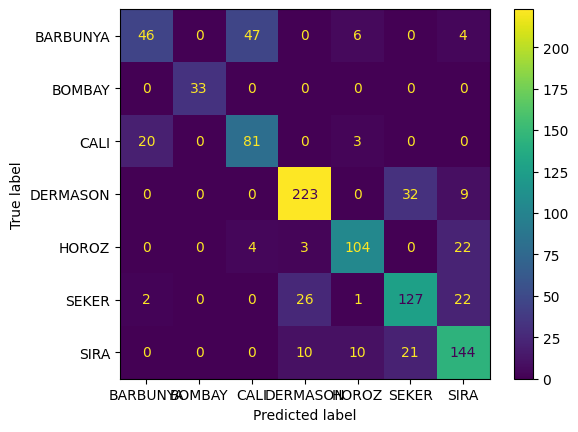

In [20]:
conf = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
conf.plot()

In [21]:
predictions = model.predict_proba(X_calib)

In [22]:
high_prob_predictions = np.amax(predictions, axis=1)

In [23]:
high_p_beans = np.where(high_prob_predictions >= 0.95)

In [24]:
its_a_match = pl.DataFrame().with_columns(match=(pl.Series(model.predict(X_calib)) == pl.Series(y_calib))).with_row_index()

In [25]:
max_acc_beans = its_a_match.filter(pl.col("index").is_in(high_p_beans[0]))

In [26]:
coverage = round(max_acc_beans["match"].mean(), 3)

In [27]:
coverage

0.896

In [28]:
n = len(X_calib)

In [29]:
# x test could also be used since data is not seen by training, and it comes from the same distribution not violating the exchangability
predictions = model.predict_proba(X_calib)
prob_true_class = predictions[np.arange(n), y_calib]

In [30]:
scores = 1- prob_true_class

In [31]:
scores

array([2.19939599e-04, 9.38184315e-01, 9.99999999e-01, 8.97733173e-03,
       2.30710967e-02, 9.58209071e-01, 7.46665300e-01, 1.41796397e-05,
       9.84333459e-01, 1.52222916e-02, 1.14534793e-02, 9.90141794e-01,
       6.15347184e-02, 5.44193885e-01, 5.52881136e-04, 2.16004992e-12,
       1.82665412e-02, 1.79839277e-06, 1.59122688e-05, 8.46198215e-05,
       5.23663283e-01, 1.53311105e-08, 5.53539371e-02, 6.72154861e-08,
       4.16884709e-05, 3.94483526e-01, 6.40909548e-10, 4.78703140e-01,
       7.32601720e-04, 1.83643120e-03, 1.05149483e-05, 4.93612773e-04,
       3.19265788e-02, 1.33430394e-06, 0.00000000e+00, 6.87170965e-03,
       7.70604066e-05, 8.23278045e-03, 1.85451654e-12, 2.24885494e-01,
       9.99982890e-01, 2.20481095e-01, 8.47558150e-06, 2.58333991e-01,
       2.82227575e-11, 1.17450364e-01, 5.84628008e-03, 1.16058107e-01,
       0.00000000e+00, 5.30133789e-08, 1.06479667e-01, 3.94197840e-01,
       1.48645540e-11, 1.86464659e-03, 8.25309117e-01, 6.64699894e-01,
      

In [32]:
alpha = 0.05 # to match 95 % prediction level
# sample size correction to 0.951
q_level = np.ceil((n+1)*(1-alpha))/n

In [33]:
# quantile calculation to know where to cutoff values so that you are sure the right
# class is there 95 % of the time
qhat = np.quantile(scores, q_level, method="higher")

In [34]:
qhat

np.float64(0.9990629054637845)

In [35]:
df_non_conf = pl.DataFrame().with_columns(non_conformity_score= 1 - prob_true_class)

In [36]:
df_non_conf.plot.bar(
    x=alt.X("non_conformity_score").bin(maxbins=20),
    y='count()'

).properties(width=500)

alt.Chart(...)

In [40]:
#qhat comes from calibration dataset so this means we have to split test set, to see how
# the calibration with the quantiles work on the test set
prediction_sets = (1-model.predict_proba(X_new) <= qhat)

In [41]:
for i in range(3):
    print(le.classes_[prediction_sets[i]])

['DERMASON']
['DERMASON']
['DERMASON' 'SEKER']


In [42]:
prediction_sets
#was übrig bleibt sind sicherere vorhergesagte prediction sets

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False,  True, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True, False,  True]])